## Model Evaluation for college scorecard - earnings prediction

This notebook will use several different supervised learning regression algorithms to model earnings after college using College Scorecard data. The models included for evaluation will be:

1. Linear Regression
1. Decision Tree
1. Random Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
seed = 12345
#load the data

data = pd.read_pickle('clean_notna_data.pickle')
X = data['X']
y = data['y']
name = X['INSTNM']
X.drop('INSTNM', axis = 1, inplace = True)
data = X.copy()
data['Y'] = y

X.head()

,MAIN,NUMBRANCH,ADM_RATE,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,...,CCSIZSET_17.0,CCSIZSET_nan,PFTFAC_ISNA,INEXPFTE_ISNA,AVGFACSAL_ISNA,GRAD_DEBT_MDN_ISNA,C150_4_ISNA,ADM_RATE_ISNA,TUITION_ISNA,TUITION_OUT_ISNT_IN
0,1,1.0,0.5575,0.0426,0.0019,0.0155,0.0000,0.0000,0.031,0.0756,...,0,0,0,0,0,0,0,0,0,1
1,1,1.0,0.9117,0.0000,0.0000,0.0000,0.0006,0.0540,0.000,0.0276,...,0,0,0,0,0,0,0,0,0,1
2,1,1.0,0.9050,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0574,...,0,0,0,0,0,0,0,0,0,1
3,1,1.0,0.6931,0.0000,0.0000,0.0000,0.0000,0.0393,0.000,0.1253,...,0,0,0,0,0,0,0,0,0,1
4,1,1.0,0.8462,0.0000,0.0000,0.0000,0.0041,0.1192,0.000,0.0164,...,0,0,0,0,0,0,0,0,0,1


### Data preprocessing
We need to split the data into training and test sets. Also, we need to think about possibly centering/normalizing the data.

Normalizing may make sense at least for linear regression, so we can understand the features a little bit better

Also, we can think about using PCA (if only for visualization purposes)

In [2]:
# Split the data into training and test
# Need to figure out best way to split time series data
# Do we split based only on colleges (i.e. each college is either train or test)
# Do we split based on college and year (i.e. each data entry is either train or test)
# Another way to split?

train_test_index = {0:'',1:'',2:'',3:'',4:'',5:''}
for i in range(0,6):
    train_test_index[i] = {
        'train': X[X['YEAR'] <= i+2002].index,
        'test' : X[X['YEAR'] == i + 2003].index
    }
X.drop('YEAR', axis = 1, inplace = True)

In [3]:
from sklearn.model_selection import train_test_split
train_val_index = list()
train_val_dataset = list()
for i in range(len(train_test_index)):
    X_i = X.iloc[train_test_index[i]['train']]
    y_i = y.iloc[train_test_index[i]['train']]
    train_val_dataset.append(train_test_split(X_i,y_i,test_size = .2, random_state = seed))
    train_val_index.append((train_val_dataset[i][0].index,train_val_dataset[i][1].index))

### Linear Regression
First try: no feature scaling

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as m_s_e
from sklearn.metrics import mean_absolute_error as m_a_e

r2_array = {'train': list(), 'val': list()}
mse_array = {'train': list(), 'val': list()}
mae_array = {'train': list(), 'val': list()}

linreg_coeffs = np.zeros_like(X.columns)
for i in range(0,6):
    X_train = X.loc[train_test_index[i]['train']]
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    y_test = y.iloc[train_test_index[i]['test']]
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    r2_array['train'].append(lin_reg.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, lin_reg.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, lin_reg.predict(X_train)))
    
    r2_array['val'].append(lin_reg.score(X_test, y_test))
    mse_array['val'].append(m_s_e(y_test, lin_reg.predict(X_test)))
    mae_array['val'].append(m_a_e(y_test, lin_reg.predict(X_test)))
    
    linreg_coeffs += lin_reg.coef_
    
linreg_coeffs /= 6
print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of validation set: ',np.mean(r2_array['val']))
print('MSE of validation set: ',np.mean(mse_array['val']))
print('RMSE of validation set: ', np.sqrt(np.mean(mse_array['val'])))
print('MAE of validation set: ',np.mean(mae_array['val']))
print()
print('Coefficients:')
sorted_inds = np.argsort(-(np.abs(linreg_coeffs)))[:20]
for i in sorted_inds:
    print(X.columns[i], ': ', linreg_coeffs[i])

R^2 of training set:  0.8354695882995418
MSE of training set:  13975015.948902061
RMSE of training set:  3738.317261670291
MAE of training set:  2675.3443940099937

R^2 of validation set:  0.8171420556736374
MSE of validation set:  14893159.984053174
RMSE of validation set:  3859.1657108827517
MAE of validation set:  2843.694317869414

Coefficients:
PCIP14 :  212045.01866881785
PCIP54 :  204349.27613629596
PCIP29 :  197155.64523724545
PCIP10 :  193362.7001621794
PCIP46 :  191251.54607647573
PCIP15 :  190445.8343574128
PCIP47 :  190054.77792560027
PCIP48 :  189296.3651716092
PCIP52 :  187028.0941275571
PCIP51 :  186942.04891293033
PCIP11 :  186751.7577971547
PCIP40 :  186633.74109882617
PCIP41 :  184761.03406060088
PCIP24 :  183182.72462952873
PCIP22 :  182827.52509748563
PCIP27 :  182712.773971734
PCIP16 :  182671.52365298968
PCIP49 :  182616.41398596964
PCIP31 :  182248.37726479248
PCIP43 :  181264.37948812149


Second try: feature scaling

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

r2_array = {'train': list(), 'val': list()}
mse_array = {'train': list(), 'val': list()}
mae_array = {'train': list(), 'val': list()}

linreg_coeffs = np.zeros_like(X.columns)

accuracy_array = {'train': list(), 'val': list()}
for i in range(0,6):
    X_train = X_scaled[train_test_index[i]['train']]
    y_train = y[train_test_index[i]['train']]
    X_test = X_scaled[train_test_index[i]['test']]
    y_test = y[train_test_index[i]['test']]
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    r2_array['train'].append(lin_reg.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, lin_reg.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, lin_reg.predict(X_train)))
    
    r2_array['val'].append(lin_reg.score(X_test, y_test))
    mse_array['val'].append(m_s_e(y_test, lin_reg.predict(X_test)))
    mae_array['val'].append(m_a_e(y_test, lin_reg.predict(X_test)))
    
    linreg_coeffs += lin_reg.coef_
    
linreg_coeffs /= 6
print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of validation set: ',np.mean(r2_array['val']))
print('MSE of validation set: ',np.mean(mse_array['val']))
print('RMSE of validation set: ', np.sqrt(np.mean(mse_array['val'])))
print('MAE of validation set: ',np.mean(mae_array['val']))
print()
print('Coefficients:')
sorted_inds = np.argsort(-(np.abs(linreg_coeffs)))[:10]
for i in sorted_inds:
    print(X.columns[i], ': ', linreg_coeffs[i])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


R^2 of training set:  0.834907174750349
MSE of training set:  14023707.175070435
RMSE of training set:  3744.824051283376
MAE of training set:  2681.947299191741

R^2 of validation set:  -1.9460008455185967e+21
MSE of validation set:  1.5572372309715359e+29
RMSE of validation set:  394618452555317.75
MAE of validation set:  7073878484933.141

Coefficients:
REGION_Plains  :  1.5006499768142328e+16
STABBR_NH :  1.2563879000136318e+16
STABBR_DC :  -1.237218394430573e+16
STABBR_DC :  1.201386767045569e+16
STABBR_NV :  -1.1845352742386542e+16
STABBR_NV :  1.1845352742386478e+16
STABBR_AZ :  1.1760069487059712e+16
STABBR_KS :  -1.157721261925783e+16
STABBR_MT :  1.1519790645060174e+16
STABBR_MT :  -1.1481237625360754e+16


### Random forest


In [6]:
from sklearn.ensemble import RandomForestRegressor 

n_estimators = 120
max_features = [0.3,0.4,0.5,0.66,0.75,0.9,0.99, 1]

# initialize accuracy dict which will have accuracy values for each run of the parameter tuning
accuracy_dict = dict()
for max_f in max_features:
    accuracy_dict[max_f] = {'r2':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0},
                                'oob':
                                    {'list':list(),
                                     'mean': 0}},
                            'mse':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0},
                                'oob':
                                    {'list':list(),
                                     'mean': 0}},
                            'mae':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0},
                                'oob':
                                    {'list':list(),
                                     'mean': 0}}}

for max_f in max_features:
    for i in range(0,6):
        X_train = X.loc[train_test_index[i]['train']]
        y_train = y.iloc[train_test_index[i]['train']]
        X_test = X.loc[train_test_index[i]['test']]
        y_test = y.iloc[train_test_index[i]['test']]
        rand_forest = RandomForestRegressor(n_estimators = n_estimators, max_features = max_f,
                                        criterion = 'mse', oob_score = True, random_state = seed)
        rand_forest.fit(X_train, y_train)

        accuracy_dict[max_f]['r2']['oob']['list'].append(rand_forest.oob_score_)
        accuracy_dict[max_f]['mse']['oob']['list'].append(m_s_e(y_train, rand_forest.oob_prediction_))
        accuracy_dict[max_f]['mae']['oob']['list'].append(m_a_e(y_train, rand_forest.oob_prediction_))
        
        accuracy_dict[max_f]['r2']['train']['list'].append(rand_forest.score(X_train, y_train))
        accuracy_dict[max_f]['mse']['train']['list'].append(m_s_e(y_train, rand_forest.predict(X_train)))
        accuracy_dict[max_f]['mae']['train']['list'].append(m_a_e(y_train, rand_forest.predict(X_train)))
        
        accuracy_dict[max_f]['r2']['test']['list'].append(rand_forest.score(X_test, y_test))
        accuracy_dict[max_f]['mse']['test']['list'].append(m_s_e(y_test, rand_forest.predict(X_test)))
        accuracy_dict[max_f]['mae']['test']['list'].append(m_a_e(y_test, rand_forest.predict(X_test)))
    
    
    accuracy_dict[max_f]['r2']['oob']['mean'] = np.mean(accuracy_dict[max_f]['r2']['oob']['list'])
    accuracy_dict[max_f]['mse']['oob']['mean'] = np.mean(accuracy_dict[max_f]['mse']['oob']['list'])
    accuracy_dict[max_f]['mae']['oob']['mean'] = np.mean(accuracy_dict[max_f]['mae']['oob']['list'])
    
    accuracy_dict[max_f]['r2']['train']['mean'] = np.mean(accuracy_dict[max_f]['r2']['train']['list'])
    accuracy_dict[max_f]['mse']['train']['mean'] = np.mean(accuracy_dict[max_f]['mse']['train']['list'])
    accuracy_dict[max_f]['mae']['train']['mean'] = np.mean(accuracy_dict[max_f]['mae']['train']['list'])
                            
    accuracy_dict[max_f]['r2']['test']['mean'] = np.mean(accuracy_dict[max_f]['r2']['test']['list'])
    accuracy_dict[max_f]['mse']['test']['mean'] = np.mean(accuracy_dict[max_f]['mse']['test']['list'])
    accuracy_dict[max_f]['mae']['test']['mean'] = np.mean(accuracy_dict[max_f]['mae']['test']['list'])
    print(max_f)
                            
#change other parameters as we see fit (probably max_depth, min_size_leaf, min_size_split)

0.3
0.4
0.5
0.66
0.75
0.9
0.99
1


In [7]:
column_pairs = list()
groups = ['oob', 'train', 'test']
metrics = ['r2', 'rmse', 'mae']
for group in groups:
    for metric in metrics:
        column_pairs.append((group, metric))

micolumns = pd.MultiIndex.from_tuples(column_pairs)

accuracy_means = pd.DataFrame(columns = micolumns)

In [8]:
for max_f in max_features:
    oob_r2 = accuracy_dict[max_f]['r2']['oob']['mean']
    oob_mse = accuracy_dict[max_f]['mse']['oob']['mean']
    oob_rmse = np.sqrt(oob_mse)
    oob_mae = accuracy_dict[max_f]['mae']['oob']['mean']
    
    train_r2 = accuracy_dict[max_f]['r2']['train']['mean']
    train_mse = accuracy_dict[max_f]['mse']['train']['mean']
    train_rmse = np.sqrt(train_mse)
    train_mae = accuracy_dict[max_f]['mae']['train']['mean']
    
    test_r2 = accuracy_dict[max_f]['r2']['test']['mean']
    test_mse = accuracy_dict[max_f]['mse']['test']['mean']
    test_rmse = np.sqrt(test_mse)
    test_mae = accuracy_dict[max_f]['mae']['test']['mean']
    
    accuracy_means.loc[max_f] = [oob_r2, oob_rmse, oob_mae,train_r2,train_rmse,train_mae,
                                 test_r2,test_rmse,test_mae]
accuracy_means.sort_index(inplace = True)
accuracy_means

oob                               train                           \
            r2         rmse          mae        r2         rmse         mae   
0.30  0.886227  3126.369177  2065.003002  0.978362  1361.426834  822.559732   
0.40  0.888036  3100.777407  2058.357141  0.978633  1352.652946  819.797976   
0.50  0.888383  3096.232261  2066.169908  0.978763  1348.589436  822.352180   
0.66  0.886829  3117.640617  2070.745814  0.978560  1355.038700  823.995494   
0.75  0.886953  3115.671492  2071.002894  0.978575  1354.472646  823.968346   
0.90  0.885997  3128.555858  2083.861919  0.978444  1358.553540  828.768269   
0.99  0.885527  3134.577940  2091.412625  0.978411  1359.446839  831.380289   
1.00  0.859112  3484.577935  2251.436674  0.974627  1476.325531  891.387776   

          test                            
            r2         rmse          mae  
0.30  0.910287  2708.131001  1981.932641  
0.40  0.909066  2725.348327  1981.604363  
0.50  0.907719  2744.741094  1998.356494  
0.66  0.905881  2770.640279  2009.547536  
0.75  0.905089  2783.574444  2018.715208  
0.90  0.901416  2835.883118  2040.261954  
0.99  0.900096  2854.509247  2046.789965  
1.00  0.911089  2700.385617  1954.955274

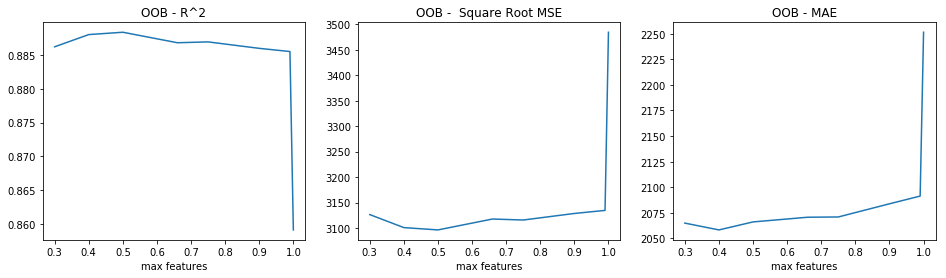

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(16,4))
ax1.plot(accuracy_means.index, accuracy_means['oob', 'r2'])
ax1.title.set_text('OOB - R^2')
ax1.set_xlabel('max features')
ax2.plot(accuracy_means.index, accuracy_means['oob', 'rmse'])
ax2.title.set_text('OOB -  Square Root MSE')
ax2.set_xlabel('max features')
ax3.plot(accuracy_means.index, accuracy_means['oob', 'mae'])
ax3.title.set_text('OOB - MAE')
ax3.set_xlabel('max features')
plt.show()

##### Using optimal max_features to find feature importance

In [10]:
best_max_f = 0.5

r2_array = {'train': list(), 'test': list()}
mse_array = {'train': list(), 'test': list()}
mae_array = {'train': list(), 'test': list()}

feature_importances = np.zeros_like(X.columns)
for i in range(0,6):
    X_train = X.loc[train_test_index[i]['train']]
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    y_test = y.iloc[train_test_index[i]['test']]
    rand_forest = RandomForestRegressor(criterion = 'mse',oob_score = True, max_features = best_max_f,
                                        random_state = seed, n_estimators = 100)
    rand_forest.fit(X_train, y_train)
    
    oob_array.append(rand_forest.oob_score_)
    
    r2_array['train'].append(rand_forest.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, rand_forest.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, rand_forest.predict(X_train)))
    
    r2_array['test'].append(rand_forest.score(X_test, y_test))
    mse_array['test'].append(m_s_e(y_test, rand_forest.predict(X_test)))
    mae_array['test'].append(m_a_e(y_test, rand_forest.predict(X_test)))
    
    feature_importances += rand_forest.feature_importances_
feature_importances /= 6

print('OOB score : ', np.mean(oob_array))
print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of Test set: ',np.mean(r2_array['test']))
print('MSE of Test set: ',np.mean(mse_array['test']))
print('RMSE of Test set: ', np.sqrt(np.mean(mse_array['test'])))
print('MAE of Test set: ',np.mean(mae_array['test']))
print()

NameError: name 'oob_array' is not defined

In [ ]:
x = np.arange(20)
sorted_inds = np.argsort(-(feature_importances))[:20]
sorted_colnames = X.columns[sorted_inds]
fig = plt.figure(figsize = (15,5))
plt.bar(x,feature_importances[sorted_inds], width = 0.8)
plt.xticks(x,(sorted_colnames))
plt.show()
for i in range(0,20):
    print(sorted_colnames[i],': ', feature_importances[sorted_inds[i]])

Least accurate predictions

In [ ]:
prediction = rand_forest.predict(X_test)
diff = y_test - prediction
absdiff = np.abs(prediction - y_test)
sorted_inds = np.argsort(-(absdiff))[:10]

for i in sorted_inds:
    name_index = train_test_index[5]['test'][i]
    print(name[name_index])
    print('predicted value:\t',prediction[i])
    print('real value:\t\t', y_test[name_index])
    print('difference:\t\t', diff[name_index])
    print()

Most accurate predictions

In [ ]:
prediction = rand_forest.predict(X_test)
diff = y_test - prediction
absdiff = np.abs(prediction - y_test)
sorted_inds = np.argsort(absdiff)[:10]

for i in sorted_inds:
    name_index = train_test_index[5]['test'][i]
    print(name[name_index])
    print(prediction[i])
    print(y_test[name_index])
    print(diff[name_index])
    print()

## Gradient Tree Boosting

While Random Forest is an *averaging* ensemble method, gradient tree boosting is by contrast a *boosting* ensenble method by which base estimators are built sequentially and the goal is to reduce the bias of the combined estimator. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Model

#Set up arrays for evaluating results
r2_array = {'train': list(), 'test': list()}
mse_array = {'train': list(), 'test': list()}
mae_array = {'train': list(), 'test': list()}

# To start will use these hyperparameters
loss = 'ls' #default -- least squares
n_estimators = 300 #default is 100 but GB is very robust to overfitting so ok to use more
learning_rate = 0.1 #default
max_depth = 1 #default


feature_importances = np.zeros_like(X.columns)
for i in range(0,6):
    X_train = X.loc[train_test_index[i]['train']]
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    y_test = y.iloc[train_test_index[i]['test']]
    gbr = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
        max_depth=max_depth, random_state=0, loss=loss)
    gbr.fit(X_train, y_train)
    
    r2_array['train'].append(gbr.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, gbr.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, gbr.predict(X_train)))
    
    r2_array['test'].append(gbr.score(X_test, y_test))
    mse_array['test'].append(m_s_e(y_test, gbr.predict(X_test)))
    mae_array['test'].append(m_a_e(y_test, gbr.predict(X_test)))
    
    feature_importances += gbr.feature_importances_
feature_importances /= 6


print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of Test set: ',np.mean(r2_array['test']))
print('MSE of Test set: ',np.mean(mse_array['test']))
print('RMSE of Test set: ', np.sqrt(np.mean(mse_array['test'])))
print('MAE of Test set: ',np.mean(mae_array['test']))
print()

R^2 of training set:  0.7970703691610118
MSE of training set:  17231561.540246706
RMSE of training set:  4151.091608269649
MAE of training set:  2993.2639439915133

R^2 of Test set:  0.7687930547559625
MSE of Test set:  18852073.165420484
RMSE of Test set:  4341.897415349709
MAE of Test set:  3243.28472767627



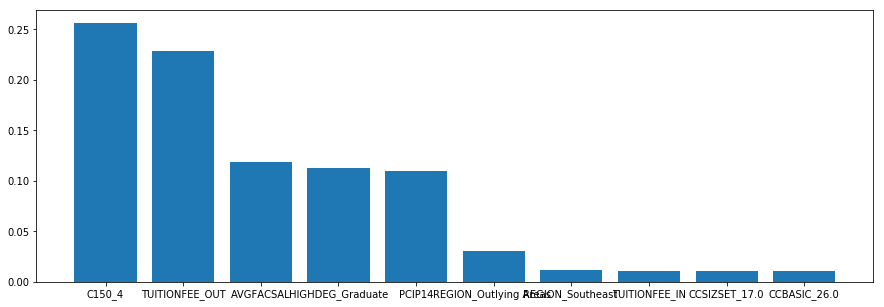

C150_4 :  0.25594808410223996
TUITIONFEE_OUT :  0.22848274860764448
AVGFACSAL :  0.11880080099443811
HIGHDEG_Graduate :  0.11244358688800876
PCIP14 :  0.11005833207934879
REGION_Outlying Areas  :  0.030557174502364868
REGION_Southeast  :  0.011649705965928703
TUITIONFEE_IN :  0.010839728740698475
CCSIZSET_17.0 :  0.01080181735185917
CCBASIC_26.0 :  0.01060953060730351


In [15]:
# Plot feature importance

x = np.arange(10)
sorted_inds = np.argsort(-(feature_importances))[:10]
sorted_colnames = X.columns[sorted_inds]
fig = plt.figure(figsize = (15,5))
plt.bar(x,feature_importances[sorted_inds], width = 0.8)
plt.xticks(x,(sorted_colnames))
plt.show()
for i in range(0,10):
    print(sorted_colnames[i],': ', feature_importances[sorted_inds[i]])

Text(0, 0.5, 'Deviance')

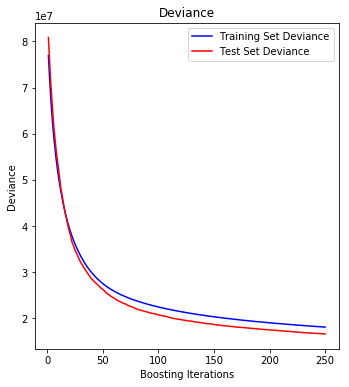

In [14]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(n_estimators) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

### delete below here

In [ ]:
# Will follow same max_features tuning process as Random Forest above

max_features = [0.3,0.4,0.5,0.66,0.75,0.9,0.99, 1]

# initialize accuracy dict which will have accuracy values for each run of the parameter tuning
gbr_accuracy_dict = dict()
for max_f in max_features:
    gbr_accuracy_dict[max_f] = {'r2':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0}},
                            'mse':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0}},
                            'mae':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0}}}

#Model=============================
for max_f in max_features:
    for i in range(0,6):
        X_train = X.loc[train_test_index[i]['train']]
        y_train = y.iloc[train_test_index[i]['train']]
        X_test = X.loc[train_test_index[i]['test']]
        y_test = y.iloc[train_test_index[i]['test']]
    
        gbr = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
        max_depth=max_depth, random_state=0, loss=loss).fit(X_train, y_train)
        
        gbr_accuracy_dict[max_f]['r2']['train']['list'].append(gbr.score(X_train, y_train))
        gbr_accuracy_dict[max_f]['mse']['train']['list'].append(m_s_e(y_train, gbr.predict(X_train)))
        gbr_accuracy_dict[max_f]['mae']['train']['list'].append(m_a_e(y_train, gbr.predict(X_train)))
        
        gbr_accuracy_dict[max_f]['r2']['test']['list'].append(gbr.score(X_test, y_test))
        gbr_accuracy_dict[max_f]['mse']['test']['list'].append(m_s_e(y_test, gbr.predict(X_test)))
        gbr_accuracy_dict[max_f]['mae']['test']['list'].append(m_a_e(y_test, gbr.predict(X_test)))
    
    gbr_accuracy_dict[max_f]['r2']['train']['mean'] = np.mean(gbr_accuracy_dict[max_f]['r2']['train']['list'])
    gbr_accuracy_dict[max_f]['mse']['train']['mean'] = np.mean(gbr_accuracy_dict[max_f]['mse']['train']['list'])
    gbr_accuracy_dict[max_f]['mae']['train']['mean'] = np.mean(gbr_accuracy_dict[max_f]['mae']['train']['list'])
                            
    gbr_accuracy_dict[max_f]['r2']['test']['mean'] = np.mean(gbr_accuracy_dict[max_f]['r2']['test']['list'])
    gbr_accuracy_dict[max_f]['mse']['test']['mean'] = np.mean(gbr_accuracy_dict[max_f]['mse']['test']['list'])
    gbr_accuracy_dict[max_f]['mae']['test']['mean'] = np.mean(gbr_accuracy_dict[max_f]['mae']['test']['list'])

In [ ]:
column_pairs = list()
groups = ['train', 'test']
metrics = ['r2', 'rmse', 'mae']
for group in groups:
    for metric in metrics:
        column_pairs.append((group, metric))

micolumns = pd.MultiIndex.from_tuples(column_pairs)

accuracy_means = pd.DataFrame(columns = micolumns)